In [10]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk

project_root = "/accounts/masters/quannm/uplift_project"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import TEST_DATA, CONVERSION_VALUE
try:
    from src.agents.agent import PIDBiddingAgent 
    print("PIDBiddingAgent imported successfully!")
except ImportError:
    print("Fail to import agent")

PIDBiddingAgent imported successfully!


In [11]:
from src.config import TEST_DATA, CONVERSION_VALUE
from src.agents.agent import PIDBiddingAgent

In [12]:
agent = PIDBiddingAgent(target_spend_rate=0.1)

# Load Data
test_df = load_from_disk(TEST_DATA).to_pandas().sample(300000, random_state=42)

# Ground Truth 
p_t = test_df['treatment'].mean()
test_df['treatment_effect_label'] = np.where(
    test_df['treatment'] == 1,
    test_df['conversion'] / p_t,
    -test_df['conversion'] / (1 - p_t))

In [13]:
features_list = [f for f in test_df.columns if f.startswith('f')]
test_df['causal_bid'] = agent.predict_bid(test_df[features_list])

In [14]:
X_baseline = test_df[features_list].values
if X_baseline.shape[1] == 17:
    X_baseline = np.column_stack([X_baseline, np.zeros(X_baseline.shape[0])])
test_df['propensity_score'] = agent.model_t.predict_proba(X_baseline)[:, 1]

In [15]:
def get_cum_lift(df, score_col):
    return df.sort_values(score_col, ascending=False).reset_index()['treatment_effect_label'].cumsum()

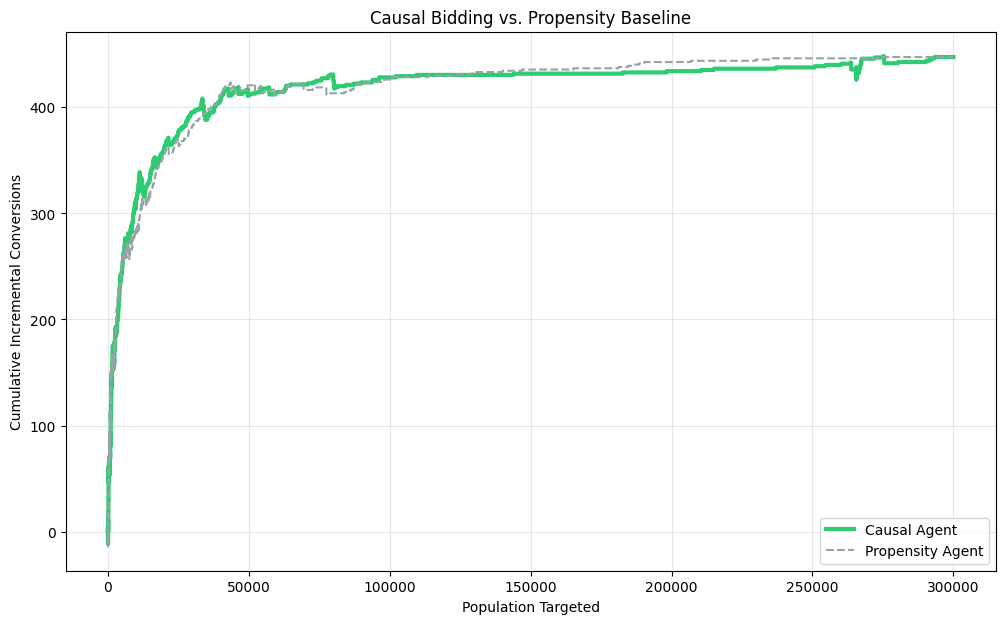

In [18]:
plt.figure(figsize=(12, 7), dpi=100)
plt.plot(get_cum_lift(test_df, 'causal_bid').values, label='Causal Agent', color='#2ecc71', linewidth=3)
plt.plot(get_cum_lift(test_df, 'propensity_score').values, label='Propensity Agent', color='#95a5a6', linestyle='--')
plt.title("Causal Bidding vs. Propensity Baseline")
plt.xlabel("Population Targeted")
plt.ylabel("Cumulative Incremental Conversions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

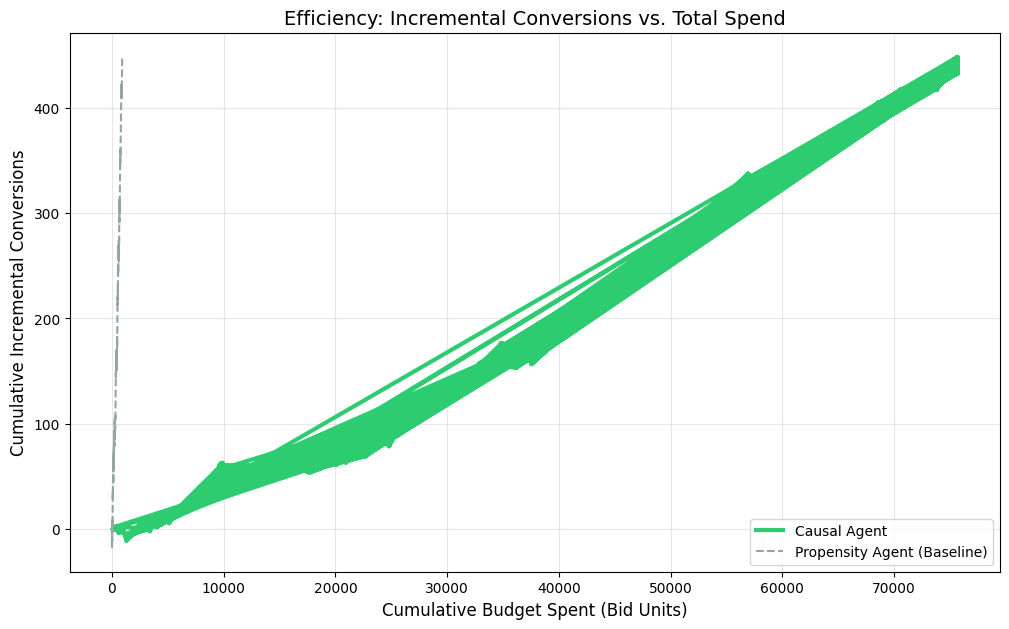

In [20]:
# Calculate the cumulative cost (sum of bids) for both agents
test_df = test_df.sort_values('causal_bid', ascending=False)
test_df['causal_cum_cost'] = test_df['causal_bid'].cumsum()
test_df['causal_cum_lift'] = test_df['treatment_effect_label'].cumsum()

test_df = test_df.sort_values('propensity_score', ascending=False)
test_df['prop_cum_cost'] = test_df['propensity_score'].cumsum() # Proxy for propensity cost
test_df['prop_cum_lift'] = test_df['treatment_effect_label'].cumsum()

# Plot Lift vs. Budget
plt.figure(figsize=(12, 7), dpi=100)
plt.plot(test_df['causal_cum_cost'], test_df['causal_cum_lift'], 
         label='Causal Agent', color='#2ecc71', linewidth=3)
plt.plot(test_df['prop_cum_cost'], test_df['prop_cum_lift'], 
         label='Propensity Agent (Baseline)', color='#95a5a6', linestyle='--')

plt.title("Efficiency: Incremental Conversions vs. Total Spend", fontsize=14)
plt.xlabel("Cumulative Budget Spent (Bid Units)", fontsize=12)
plt.ylabel("Cumulative Incremental Conversions", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()